# Using Census Bureau's API to create a Choropleth Map

(Disclaimer: Code is written in Jupyter notebooks, some of the packages may not be supported by Colab)

In this example, we're going to use Census Bureau's application programming interface (API) to pull certain education variables to create a choropleth map to show common education attainment in all census tracts of Baltimore City, MD. 

The Census Bureau's API is just a more streamlined way to access data without opening large or multiple datasets. Also, the API allows users to create their own datasets specifying the specific variables of interest. Most of the Census tract data is from the American Community Survey (ACS).

To use Census Bureau's API, we have to request an API key from the Census Bureau's website. The will allow you to pull data via the API. You can request the API here:  https://api.census.gov/data/key_signup.html. Also, the API User Guide is a good resource on how to use your API key to pull data (https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf).

When using the API, you have to must know the Census variable names for the data of interest. Please keep in mind that Census variable names are not uniform. It depends on which data you are using (ACS, Dicennial Census, Economic Census). In this example, our data will be based on the ACS 5-year data profiles for 2017. The Census variable names for those data are listed here: https://api.census.gov/data/2017/acs/acs5/profile/variables.html

Since we got all that stuff out of the way, let's get started!!!

Part 1: Using the Census Bureau's API to pull ACS data by census tract and creating a pandas dataframe from those data.

First, let's import packages that will allow us to access the Census Bureau's API. We will be using Geopandas to populate the map.

In [1]:
pwd

'/Users/aaronwoodward'

In [27]:
#Importing packages. Please note that some of these packages (i.e., census, cenpy and geopandas) may need to be 
#pip installed in your terminal
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, shape
from census import Census
import cenpy as cen
from us import states

import matplotlib.pyplot as plt
%matplotlib inline

Second, let's access the Census Bureau's API through our API key.

In [3]:
c = Census("ENTER KEY HERE")
df = c.acs5dp.get(('NAME', 'DP02_0059PE', 'DP02_0060PE', 'DP02_0061PE', 'DP02_0062PE', 'DP02_0063PE', 'DP02_0064PE', 
                   'DP02_0065PE'), 
                  {'for': 'tract:*', 'in': 'state:%s county:510' % states.MD.fips}
                 )

So you must be wondering: What is the code doing here? 

First, we assign our API key a variable "c". Next, we pull the data of interest (or variables) using the API. We are pulling data from the most recent 5-year American Community Survey ("acs5") Data Profiles (dp). Here, you see the Census-named education variables: 

NAME: Name of census tract
DP02_0059PE: Percentage of census tract population, age 25 and over, that have less than a 9th grade education
DP02_0060PE: Percentage of census tract population, age 25 and over, 9th to 12th grade, no diploma
DP02_0061PE: Percentage of census tract population, age 25 and over, High school graduate (includes equivalency)
DP02_0062PE: Percentage of census tract population, age 25 and over, Some college, no degree
DP02_0063PE: Percentage of census tract population, age 25 and over, Associate's degree
DP02_0064PE: Percentage of census tract population, age 25 and over, Bachelor's degree
DP02_0065PE: Percentage of census tract population, age 25 and over, Graduate or professional degree

Lastly, we indicate that we want data for all the census tracts ('for':'tract*') in Baltimore City (county code: 510), MD (% states.MD.fips).

In [4]:
#Convert pulled data into a pandas dataframe
from pandas import Series, DataFrame

In [5]:
df = pd.DataFrame(data = df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 11 columns):
NAME           200 non-null object
DP02_0059PE    200 non-null float64
DP02_0060PE    200 non-null float64
DP02_0061PE    200 non-null float64
DP02_0062PE    200 non-null float64
DP02_0063PE    200 non-null float64
DP02_0064PE    200 non-null float64
DP02_0065PE    200 non-null float64
state          200 non-null object
county         200 non-null object
tract          200 non-null object
dtypes: float64(7), object(4)
memory usage: 17.3+ KB


In [6]:
df.head(10)

,NAME,DP02_0059PE,DP02_0060PE,DP02_0061PE,DP02_0062PE,DP02_0063PE,DP02_0064PE,DP02_0065PE,state,county,tract
0,"Census Tract 1102, Baltimore city, Maryland",2.6,6.5,6.5,10.6,5.2,31.5,37.1,24,510,110200
1,"Census Tract 203, Baltimore city, Maryland",1.6,3.4,8.1,6.9,3.7,31.8,44.5,24,510,020300
2,"Census Tract 1504, Baltimore city, Maryland",5.2,20.3,35.8,23.3,2.3,10.0,3.1,24,510,150400
3,"Census Tract 102, Baltimore city, Maryland",1.3,3.3,9.7,8.8,1.8,43.2,31.9,24,510,010200
4,"Census Tract 604, Baltimore city, Maryland",3.9,6.4,18.7,14.3,5.8,22.5,28.4,24,510,060400
5,"Census Tract 1604, Baltimore city, Maryland",3.9,14.0,43.8,21.5,11.7,1.8,3.3,24,510,160400
6,"Census Tract 1607, Baltimore city, Maryland",2.4,13.9,47.3,16.5,7.7,8.5,3.8,24,510,160700
7,"Census Tract 1702, Baltimore city, Maryland",4.2,23.1,43.1,17.3,2.5,5.6,4.3,24,510,170200
8,"Census Tract 1801, Baltimore city, Maryland",4.9,28.6,49.1,12.7,3.0,1.2,0.5,24,510,180100
9,"Census Tract 1803, Baltimore city, Maryland",5.2,3.8,28.9,16.0,4.7,18.1,23.4,24,510,180300


In [7]:
#Let's rename our variables so that they're easier to understand.
df = df.rename(columns={'DP02_0059PE':'Less_than_HS','DP02_0060PE':'Some_HS','DP02_0061PE':'HS_graduate_GED',
                        'DP02_0062PE':'Some_college', 'DP02_0063PE':'Associates', 'DP02_0064PE':'Bachelors',
                        'DP02_0065PE':'Advanced'})

In [8]:
df.head()

,NAME,Less_than_HS,Some_HS,HS_graduate_GED,Some_college,Associates,Bachelors,Advanced,state,county,tract
0,"Census Tract 1102, Baltimore city, Maryland",2.6,6.5,6.5,10.6,5.2,31.5,37.1,24,510,110200
1,"Census Tract 203, Baltimore city, Maryland",1.6,3.4,8.1,6.9,3.7,31.8,44.5,24,510,020300
2,"Census Tract 1504, Baltimore city, Maryland",5.2,20.3,35.8,23.3,2.3,10.0,3.1,24,510,150400
3,"Census Tract 102, Baltimore city, Maryland",1.3,3.3,9.7,8.8,1.8,43.2,31.9,24,510,010200
4,"Census Tract 604, Baltimore city, Maryland",3.9,6.4,18.7,14.3,5.8,22.5,28.4,24,510,060400


Next, we're going to create the common educational attainment variables. These variables will be binary (or boolean) data types. We're going to assign these Census variables that we've pulled to these common educational attainment variables. These variables will be used in identifying the common educational attainment for each census tract in Baltimore City, MD. 

In [14]:
#may not need code

df['cea_lessthanhs'] = 0
df['cea_HSdipGED'] = 0
df['cea_Somecollege'] = 0
df['cea_Bachelors'] = 0
df['cea_Advanced'] = 0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NAME                   200 non-null    object 
 1   Less_than_HS           200 non-null    float64
 2   Some_HS                200 non-null    float64
 3   HS_graduate_GED        200 non-null    float64
 4   Some_college           200 non-null    float64
 5   Associates             200 non-null    float64
 6   Bachelors              200 non-null    float64
 7   Graduate_Professional  200 non-null    float64
 8   state                  200 non-null    object 
 9   county                 200 non-null    object 
 10  tract                  200 non-null    object 
 11  cea_lessthanhs         200 non-null    int64  
 12  cea_HSdipGED           200 non-null    int64  
 13  cea_Somecollege        200 non-null    int64  
 14  cea_Bachelors          200 non-null    int64  
 15  cea_Ad

In [15]:
#MAY NOT NEED CODE
#Converting the common educational attainment variables data types from integers to boolean
df['cea_lessthanhs'] = df.cea_lessthanhs.astype(bool)
df['cea_HSdipGED'] = df.cea_HSdipGED.astype(bool)
df['cea_Somecollege'] = df.cea_Somecollege.astype(bool)
df['cea_Bachelors'] = df.cea_Bachelors.astype(bool)
df['cea_Advanced'] = df.cea_Advanced.astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NAME                   200 non-null    object 
 1   Less_than_HS           200 non-null    float64
 2   Some_HS                200 non-null    float64
 3   HS_graduate_GED        200 non-null    float64
 4   Some_college           200 non-null    float64
 5   Associates             200 non-null    float64
 6   Bachelors              200 non-null    float64
 7   Graduate_Professional  200 non-null    float64
 8   state                  200 non-null    object 
 9   county                 200 non-null    object 
 10  tract                  200 non-null    object 
 11  cea_lessthanhs         200 non-null    bool   
 12  cea_HSdipGED           200 non-null    bool   
 13  cea_Somecollege        200 non-null    bool   
 14  cea_Bachelors          200 non-null    bool   
 15  cea_Ad

Next, we're going to create a variable called "comm_educ_maxval" which gives us the max percentage across all education variables for each census tract. This variable will be helpful in determining the common educational attainment for each census tract.

In [9]:
df['comm_educ_maxval'] = df.max(axis=1)

In [10]:
df.head(10)

,NAME,Less_than_HS,Some_HS,HS_graduate_GED,Some_college,Associates,Bachelors,Advanced,state,county,tract,comm_educ_maxval
0,"Census Tract 1102, Baltimore city, Maryland",2.6,6.5,6.5,10.6,5.2,31.5,37.1,24,510,110200,37.1
1,"Census Tract 203, Baltimore city, Maryland",1.6,3.4,8.1,6.9,3.7,31.8,44.5,24,510,020300,44.5
2,"Census Tract 1504, Baltimore city, Maryland",5.2,20.3,35.8,23.3,2.3,10.0,3.1,24,510,150400,35.8
3,"Census Tract 102, Baltimore city, Maryland",1.3,3.3,9.7,8.8,1.8,43.2,31.9,24,510,010200,43.2
4,"Census Tract 604, Baltimore city, Maryland",3.9,6.4,18.7,14.3,5.8,22.5,28.4,24,510,060400,28.4
5,"Census Tract 1604, Baltimore city, Maryland",3.9,14.0,43.8,21.5,11.7,1.8,3.3,24,510,160400,43.8
6,"Census Tract 1607, Baltimore city, Maryland",2.4,13.9,47.3,16.5,7.7,8.5,3.8,24,510,160700,47.3
7,"Census Tract 1702, Baltimore city, Maryland",4.2,23.1,43.1,17.3,2.5,5.6,4.3,24,510,170200,43.1
8,"Census Tract 1801, Baltimore city, Maryland",4.9,28.6,49.1,12.7,3.0,1.2,0.5,24,510,180100,49.1
9,"Census Tract 1803, Baltimore city, Maryland",5.2,3.8,28.9,16.0,4.7,18.1,23.4,24,510,180300,28.9


Next, were going to create the "comm_educ_att" which will assign common educational attainment for each census tract. In order to do this we need to a couple things...

1. Make a subset dataframe that only includes education variables

In [11]:
df1 = df[['Less_than_HS','Some_HS','HS_graduate_GED','Some_college','Associates','Bachelors','Advanced']]

In [12]:
df1 = pd.DataFrame(data = df1)

In [13]:
df1.head()

,Less_than_HS,Some_HS,HS_graduate_GED,Some_college,Associates,Bachelors,Advanced
0,2.6,6.5,6.5,10.6,5.2,31.5,37.1
1,1.6,3.4,8.1,6.9,3.7,31.8,44.5
2,5.2,20.3,35.8,23.3,2.3,10.0,3.1
3,1.3,3.3,9.7,8.8,1.8,43.2,31.9
4,3.9,6.4,18.7,14.3,5.8,22.5,28.4


2. We base the comm_educ_att on the educational attainment variable that has the highest percentage.

In [14]:
df['comm_educ_att'] = df1.idxmax(axis=1)

In [15]:
df.head()

,NAME,Less_than_HS,Some_HS,HS_graduate_GED,Some_college,Associates,Bachelors,Advanced,state,county,tract,comm_educ_maxval,comm_educ_att
0,"Census Tract 1102, Baltimore city, Maryland",2.6,6.5,6.5,10.6,5.2,31.5,37.1,24,510,110200,37.1,Advanced
1,"Census Tract 203, Baltimore city, Maryland",1.6,3.4,8.1,6.9,3.7,31.8,44.5,24,510,020300,44.5,Advanced
2,"Census Tract 1504, Baltimore city, Maryland",5.2,20.3,35.8,23.3,2.3,10.0,3.1,24,510,150400,35.8,HS_graduate_GED
3,"Census Tract 102, Baltimore city, Maryland",1.3,3.3,9.7,8.8,1.8,43.2,31.9,24,510,010200,43.2,Bachelors
4,"Census Tract 604, Baltimore city, Maryland",3.9,6.4,18.7,14.3,5.8,22.5,28.4,24,510,060400,28.4,Advanced


Now you see the common educational attainment for each census tract. Now, let's move to Part 2: Working in with Shapefiles that contain geospatial data.

In [16]:
import fiona as fiona #may not need this pacakge but importing it just in case

In [17]:
pwd

'/Users/aaronwoodward'

We've downloaded ou Census geospatial data or shapefile from Census' TIGERweb (https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_24_tract). When clicked on the link, a zip file will be downloaded. When the file is unzipped, there will be numerous files that are enclosed. We are interested in the file that has the ".shp" extension. This is the shapefile we will be using to access geospatial data to create our map. Be sure that you set your working drive to the drive and folder location of the data. We will be use geopandas to read the data in the shapefile and converting the dataset into a pandas dataframe.

In [18]:
cd '/Users/aaronwoodward/Desktop/Census/tl_2017_24_tract'

/Users/aaronwoodward/Desktop/Census/tl_2017_24_tract


In [35]:
MD_tracts = gpd.read_file("tl_2017_24_tract.shp")

This shapefile includes the data for all of the census blocks in the State of Maryland. 

In [36]:
MD_tracts.head(10)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,24,005,403100,24005403100,4031,Census Tract 4031,G5020,S,1913596,0,+39.3530950,-076.7333148,"POLYGON ((-76.74491 39.35986, -76.74431 39.359..."
1,24,005,403201,24005403201,4032.01,Census Tract 4032.01,G5020,S,1764538,0,+39.3549038,-076.7215235,"POLYGON ((-76.73369 39.36204, -76.73290 39.362..."
2,24,033,807304,24033807304,8073.04,Census Tract 8073.04,G5020,S,1776716,0,+39.0249780,-076.9594342,"POLYGON ((-76.97171 39.01858, -76.97164 39.018..."
3,24,033,807305,24033807305,8073.05,Census Tract 8073.05,G5020,S,3029496,4428,+39.0121779,-076.9635510,"POLYGON ((-76.97728 39.01095, -76.97714 39.011..."
4,24,033,807405,24033807405,8074.05,Census Tract 8074.05,G5020,S,7093436,27200,+39.0383526,-076.9283090,"POLYGON ((-76.94986 39.02208, -76.94944 39.024..."
5,24,033,807407,24033807407,8074.07,Census Tract 8074.07,G5020,S,5841154,84091,+39.0676225,-076.9228098,"POLYGON ((-76.94631 39.05241, -76.94570 39.053..."
6,24,033,803700,24033803700,8037,Census Tract 8037,G5020,S,927911,0,+38.9433616,-076.8881511,"POLYGON ((-76.89717 38.94563, -76.89596 38.945..."
7,24,027,606603,24027606603,6066.03,Census Tract 6066.03,G5020,S,4631692,0,+39.2089096,-076.8448540,"POLYGON ((-76.86379 39.19696, -76.86261 39.198..."
8,24,005,400701,24005400701,4007.01,Census Tract 4007.01,G5020,S,1186715,0,+39.2847069,-076.7267257,"POLYGON ((-76.73885 39.28634, -76.73864 39.286..."
9,24,005,400702,24005400702,4007.02,Census Tract 4007.02,G5020,S,702073,0,+39.2880154,-076.7166223,"POLYGON ((-76.72511 39.28975, -76.72454 39.289..."


In [32]:
#MD_tracts = pd.DataFrame(MD_tracts)

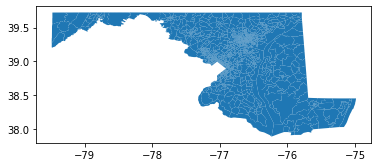

In [38]:
MD_tracts.plot() #Before executing this code, you have to pip install descartes in order to show map.

Since we are only interested in the census blocks of Baltimore City, MD, we have to filter by county code.

In [39]:
BalCity_tracts = MD_tracts[(MD_tracts_gdf['COUNTYFP'] == "510")]

In [40]:
BalCity_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
188,24,510,240300,24510240300,2403,Census Tract 2403,G5020,S,200561,0,+39.2758586,-076.6105164,"POLYGON ((-76.61262 39.27889, -76.61149 39.278..."
189,24,510,250101,24510250101,2501.01,Census Tract 2501.01,G5020,S,962778,0,+39.2771141,-076.7003721,"POLYGON ((-76.71098 39.27792, -76.71071 39.278..."
190,24,510,250102,24510250102,2501.02,Census Tract 2501.02,G5020,S,737636,0,+39.2773395,-076.6901916,"POLYGON ((-76.69576 39.27784, -76.69572 39.277..."
191,24,510,250103,24510250103,2501.03,Census Tract 2501.03,G5020,S,2587959,0,+39.2687004,-076.6776588,"POLYGON ((-76.69741 39.27239, -76.69599 39.272..."
192,24,510,250203,24510250203,2502.03,Census Tract 2502.03,G5020,S,923337,361546,+39.2451631,-076.6164269,"POLYGON ((-76.62527 39.24907, -76.62521 39.249..."


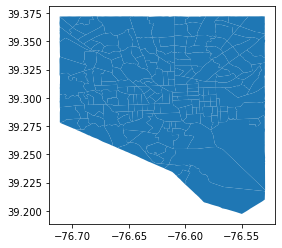

In [41]:
BalCity_tracts.plot() 

In [42]:
BalCity_tracts = BalCity_tracts.rename(columns={'TRACTCE':'tract'})
BalCity_tracts.head()

,STATEFP,COUNTYFP,tract,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
188,24,510,240300,24510240300,2403,Census Tract 2403,G5020,S,200561,0,+39.2758586,-076.6105164,"POLYGON ((-76.61262 39.27889, -76.61149 39.278..."
189,24,510,250101,24510250101,2501.01,Census Tract 2501.01,G5020,S,962778,0,+39.2771141,-076.7003721,"POLYGON ((-76.71098 39.27792, -76.71071 39.278..."
190,24,510,250102,24510250102,2501.02,Census Tract 2501.02,G5020,S,737636,0,+39.2773395,-076.6901916,"POLYGON ((-76.69576 39.27784, -76.69572 39.277..."
191,24,510,250103,24510250103,2501.03,Census Tract 2501.03,G5020,S,2587959,0,+39.2687004,-076.6776588,"POLYGON ((-76.69741 39.27239, -76.69599 39.272..."
192,24,510,250203,24510250203,2502.03,Census Tract 2502.03,G5020,S,923337,361546,+39.2451631,-076.6164269,"POLYGON ((-76.62527 39.24907, -76.62521 39.249..."


Now, we have our Baltimore City map. Next, we're going to merge BalCity_tracts with the dataframe that we've created in Part 1. We're going to use the "tract" variable in both dataframes to merge.

In [43]:
#We'll call our merged dataframe "BalCity_CEA"

BalCity_CEA = pd.merge(df,BalCity_tracts, on=['tract'])
BalCity_CEA.head()

,NAME_x,Less_than_HS,Some_HS,HS_graduate_GED,Some_college,Associates,Bachelors,Advanced,state,county,...,GEOID,NAME_y,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,"Census Tract 1102, Baltimore city, Maryland",2.6,6.5,6.5,10.6,5.2,31.5,37.1,24,510,...,24510110200,1102,Census Tract 1102,G5020,S,720012,0,+39.3014593,-076.6175059,"POLYGON ((-76.62102 39.30703, -76.62100 39.307..."
1,"Census Tract 203, Baltimore city, Maryland",1.6,3.4,8.1,6.9,3.7,31.8,44.5,24,510,...,24510020300,203,Census Tract 203,G5020,S,662775,384066,+39.2808610,-076.5940789,"POLYGON ((-76.60249 39.27957, -76.60051 39.280..."
2,"Census Tract 1504, Baltimore city, Maryland",5.2,20.3,35.8,23.3,2.3,10.0,3.1,24,510,...,24510150400,1504,Census Tract 1504,G5020,S,815572,0,+39.3124588,-076.6527287,"POLYGON ((-76.65993 39.30991, -76.65992 39.310..."
3,"Census Tract 102, Baltimore city, Maryland",1.3,3.3,9.7,8.8,1.8,43.2,31.9,24,510,...,24510010200,102,Census Tract 102,G5020,S,355165,0,+39.2880851,-076.5740101,"POLYGON ((-76.57724 39.28624, -76.57651 39.286..."
4,"Census Tract 604, Baltimore city, Maryland",3.9,6.4,18.7,14.3,5.8,22.5,28.4,24,510,...,24510060400,604,Census Tract 604,G5020,S,430134,0,+39.2950986,-076.5909176,"POLYGON ((-76.59441 39.29837, -76.59411 39.298..."


In [44]:
#Just to make sure all of our variables are included, since some were hidden in the head view.
BalCity_CEA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 25 columns):
NAME_x              200 non-null object
Less_than_HS        200 non-null float64
Some_HS             200 non-null float64
HS_graduate_GED     200 non-null float64
Some_college        200 non-null float64
Associates          200 non-null float64
Bachelors           200 non-null float64
Advanced            200 non-null float64
state               200 non-null object
county              200 non-null object
tract               200 non-null object
comm_educ_maxval    200 non-null float64
comm_educ_att       200 non-null object
STATEFP             200 non-null object
COUNTYFP            200 non-null object
GEOID               200 non-null object
NAME_y              200 non-null object
NAMELSAD            200 non-null object
MTFCC               200 non-null object
FUNCSTAT            200 non-null object
ALAND               200 non-null int64
AWATER              200 non-null int64
INTPTLAT 

Finally, we can plot our map!!!

Text(0.5, 1, 'Baltimore City, MD: Common Educational Attainment per Census Tract')

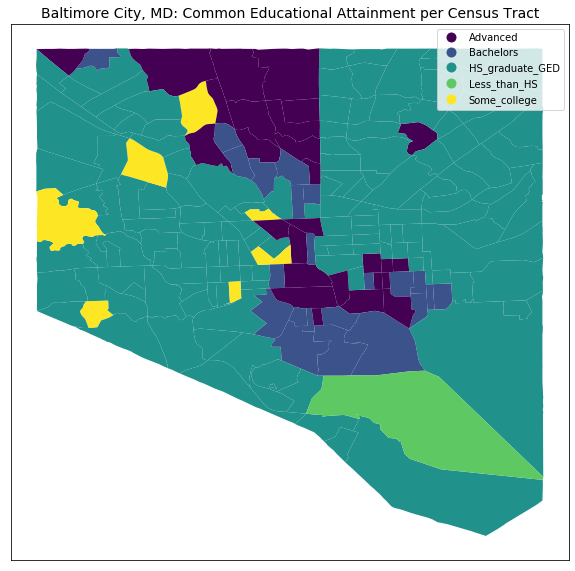

In [48]:
Balcity_gdf = gpd.GeoDataFrame(geometry = BalCity_CEA['geometry'], data = BalCity_CEA['comm_educ_att'])
fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal', xticks=[], yticks=[])
Balcity_gdf.plot(column='comm_educ_att', ax = ax, cmap = 'viridis', legend=True)
plt.title('Baltimore City, MD: Common Educational Attainment per Census Tract', size=14)